In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [21]:
# print(plt.rcParams)
plt.rcParams["font.sans-serif"] = ['Arial']
# plt.rcParams["font.size"] = 12.0
markers = ['o', 'p', 'h', 'd', 'v', '^', '<', '>']
figsize = (8, 6)

In [22]:
# sort the OCSVM results dictionary by the performance
def get_sorted_pairs_ocsvm(performance):
    values = sorted([[performance[kernel][nu][gamma]['false_positive_rate'], performance[kernel][nu][gamma]['false_negative_rate']] for kernel in performance for nu in performance[kernel] for gamma in performance[kernel][nu]], key=lambda x: x[0])
    return values

# sort the DBSCAN results dictionary by the performance
def get_sorted_pairs_dbscan(performance):
    values = sorted([[performance[layer][epsilon]['false_positive_rate'], performance[layer][epsilon]['false_negative_rate']] for layer in performance for epsilon in performance[layer]], key=lambda x: x[0])
    return values

# get best OCSVM f1 score
def get_best_ocsvm(performance):
    best_f1 = .0
    best = None
    for kernel in performance.keys():
        for nu in performance[kernel].keys():
            for gamma in performance[kernel][nu].keys():
                if performance[kernel][nu][gamma]['f1_score'] > best_f1:
                    best_f1 = performance[kernel][nu][gamma]['f1_score']
                    best = performance[kernel][nu][gamma]
    return best

# get best DBSCAN f1 score
def get_best_dbscan(performance):
    best_f1 = .0
    best = None
    for epsilon in performance.keys():
        for min_pts in performance[epsilon].keys():
            if performance[epsilon][min_pts]['f1_score'] > best_f1:
                best_f1 = performance[epsilon][min_pts]['f1_score']
                best = performance[epsilon][min_pts]
    return best

def get_curve(sorted_pairs):
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0][0]
    last_y = sorted_pairs[0][1]

    curve_fpr.append(sorted_pairs[0][0])
    curve_fnr.append(sorted_pairs[0][1])
    
    for x, y in sorted_pairs:
        if x > curve_fpr[-1] and y < curve_fnr[-1]:
            curve_fpr.append(x)
            curve_fnr.append(y)
    return curve_fpr, curve_fnr

In [23]:
with open('./models/raw-ds-results.h5', 'rb') as file:
    dict_raw = pickle.load(file)
    performance_ocsvm = dict_raw['performance_ocsvm']
    performance_dbscan = dict_raw['performance_dbscan']
    del dict_raw
# replace with raw dataset result
best_f1_full_dataset_ocsvm = get_best_ocsvm(performance_ocsvm)
print('Best model OCSVM:', best_f1_full_dataset_ocsvm)
best_f1_full_dataset_dbscan = get_best_dbscan(performance_dbscan)
print('Best model DBSCAN:', best_f1_full_dataset_dbscan)

Best model OCSVM: {'kernel': 'linear', 'nu': 0.01, 'gamma': 0.5, 'true_positive_rate': 0.9419466666666667, 'false_negative_rate': 0.05805333333333333, 'true_negative_rate': 0.9836, 'false_positive_rate': 0.0164, 'precision': 0.9829218829588162, 'recall': 0.9419466666666667, 'f1_score': 0.9619268622767791}
Best model DBSCAN: {'min_samples': 5, 'epsilon': 1.0, 'true_positive_rate': 0.8462044444444444, 'false_negative_rate': 0.15379555555555557, 'true_negative_rate': 0.735598, 'false_positive_rate': 0.264402, 'precision': 0.7626438317586529, 'recall': 0.8462044444444444, 'f1_score': 0.801771283339833}


In [24]:
with open('./models/pca-results.h5', 'rb') as file:
    dict_pca = pickle.load(file)
    performance_ocsvm_pca = dict_pca['performance_ocsvm_pca']
    performance_dbscan_pca = dict_pca['performance_dbscan_pca']
    del dict_pca

In [25]:
with open('./models/tsne_results.h5', 'rb') as file:
    dict_tsne = pickle.load(file)
    performance_ocsvm_tsne = dict_tsne['performance_ocsvm_tsne']
    performance_dbscan_tsne = dict_tsne['performance_dbscan_tsne']
    del dict_tsne

In [26]:
# dataset_filter = 'normal'
dataset_filter = 'all' # use all for final results
optimizer_name = 'SGD'
lr = 0.01
with open('./models/{}_{}_{}_accuracy_results.h5'.format(dataset_filter, optimizer_name, lr), 'rb') as file:
    dict_ae = pickle.load(file)
    performance_dbscan_encoder = dict_ae['performance_dbscan_encoder']
    performance_ocsvm_encoder = dict_ae['performance_ocsvm_encoder']
    del dict_ae

dict_keys([(40,), (100, 40), (400, 100, 40)])

## OCSVM

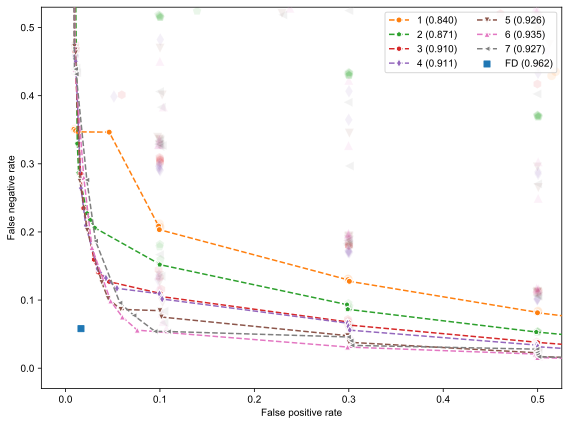

In [27]:
plt.figure(figsize=figsize)

plt.scatter(best_f1_full_dataset_ocsvm['false_positive_rate'], best_f1_full_dataset_ocsvm['false_negative_rate'], label='FD ({:.3f})'.format(best_f1_full_dataset_ocsvm['f1_score']), marker='s')

for idn, n_components in enumerate(performance_ocsvm_pca.keys()):
    
    sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_pca[n_components])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)

    best_f1 = get_best_ocsvm(performance_ocsvm_pca[n_components])
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker=markers[idn], s=80, alpha=0.1, edgecolors='white', zorder=1+idn)

    plt.plot(curve_fpr, curve_fnr, ls='--', marker=markers[idn], alpha=1., 
             markeredgecolor='white', color=ax.get_facecolors()[0], 
             label=f"{n_components} ({best_f1['f1_score']:.3f})", zorder=10+idn)
    if idn == 6: break
xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
plt.xlim([xlim, .5 - xlim])
plt.ylim([ylim, .5 - ylim])
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
l = plt.legend(ncol=2, loc=1)
l.set_zorder(20)
plt.tight_layout()
plt.savefig('./figures/accuracy_ocsvm_pca.pdf')
plt.savefig('./figures/accuracy_ocsvm_pca.svg')
plt.show()
plt.close()

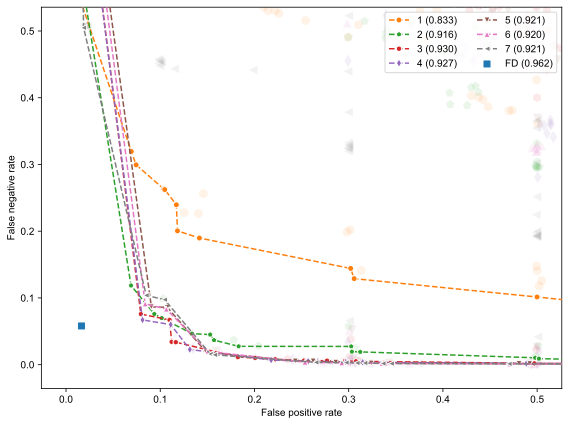

In [28]:
plt.figure(figsize=figsize)

plt.scatter(best_f1_full_dataset_ocsvm['false_positive_rate'], best_f1_full_dataset_ocsvm['false_negative_rate'], label='FD ({:.3f})'.format(best_f1_full_dataset_ocsvm['f1_score']), marker='s')

for idn, n_components in enumerate(performance_ocsvm_tsne.keys()):
    
    sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_tsne[n_components])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)

    best_f1 = get_best_ocsvm(performance_ocsvm_tsne[n_components])
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker=markers[idn], s=80, alpha=0.1, edgecolors='white', zorder=1+idn)

    plt.plot(curve_fpr, curve_fnr, ls='--', marker=markers[idn], alpha=1., 
             markeredgecolor='white', color=ax.get_facecolors()[0], 
             label=f"{n_components} ({best_f1['f1_score']:.3f})", zorder=10+idn)
    if idn == 6: break
xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
plt.xlim([xlim, .5 - xlim])
plt.ylim([ylim, .5 - ylim])
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
l = plt.legend(ncol=2, loc=1)
l.set_zorder(20)
plt.tight_layout()
plt.savefig('./figures/accuracy_ocsvm_tsne.pdf')
plt.savefig('./figures/accuracy_ocsvm_tsne.svg')
plt.show()
plt.close()

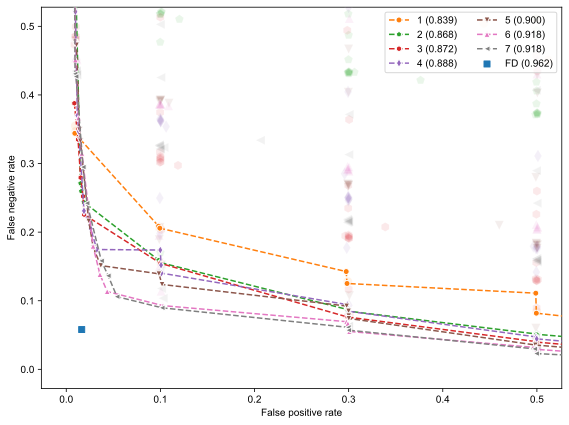

In [29]:
plt.figure(figsize=figsize)

plt.scatter(best_f1_full_dataset_ocsvm['false_positive_rate'], best_f1_full_dataset_ocsvm['false_negative_rate'], label='FD ({:.3f})'.format(best_f1_full_dataset_ocsvm['f1_score']), marker='s')

for idn, n_components in enumerate(performance_ocsvm_encoder.keys()):
    
    layer = (400, 100, 40)
    
    sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_encoder[n_components][layer])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)

    best_f1 = get_best_ocsvm(performance_ocsvm_encoder[n_components][layer])
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker=markers[idn], s=80, alpha=0.1, edgecolors='white', zorder=1+idn)

    plt.plot(curve_fpr, curve_fnr, ls='--', marker=markers[idn], alpha=1., 
             markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10+idn, 
             label=f"{n_components} ({best_f1['f1_score']:.3f})")
    if idn == 6: break
xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
plt.xlim([xlim, .5 - xlim])
plt.ylim([ylim, .5 - ylim])
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
l = plt.legend(ncol=2, loc=1)
l.set_zorder(20)
plt.tight_layout()
plt.savefig('./figures/accuracy_ocsvm_ae.pdf')
plt.savefig('./figures/accuracy_ocsvm_ae.svg')
plt.show()
plt.close()

## DBSCAN

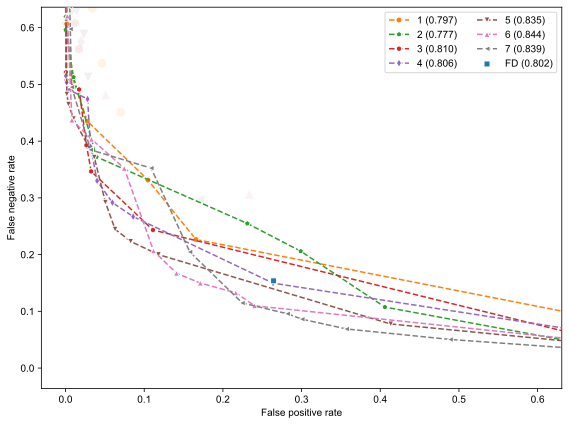

In [30]:
plt.figure(figsize=figsize)

plt.scatter(best_f1_full_dataset_dbscan['false_positive_rate'], best_f1_full_dataset_dbscan['false_negative_rate'], label='FD ({:.3f})'.format(best_f1_full_dataset_dbscan['f1_score']), 
            marker='s', edgecolors='white', zorder=30)

for idn, n_components in enumerate(performance_dbscan_pca.keys()):
    
    sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_pca[n_components])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)

    best_f1 = get_best_dbscan(performance_dbscan_pca[n_components])
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker=markers[idn], s=80, alpha=0.1, edgecolors='white', zorder=1+idn)

    plt.plot(curve_fpr, curve_fnr, ls='--', marker=markers[idn], alpha=1., 
             markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10+idn, 
             label=f"{n_components} ({best_f1['f1_score']:.3f})")
    
    if idn == 6: break
xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
plt.xlim([xlim, .6 - xlim])
plt.ylim([ylim, .6 - ylim])
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
l = plt.legend(ncol=2, loc=1)
l.set_zorder(20)
plt.tight_layout()
plt.savefig('./figures/accuracy_dbscan_pca.pdf')
plt.savefig('./figures/accuracy_dbscan_pca.svg')
plt.show()
plt.close()

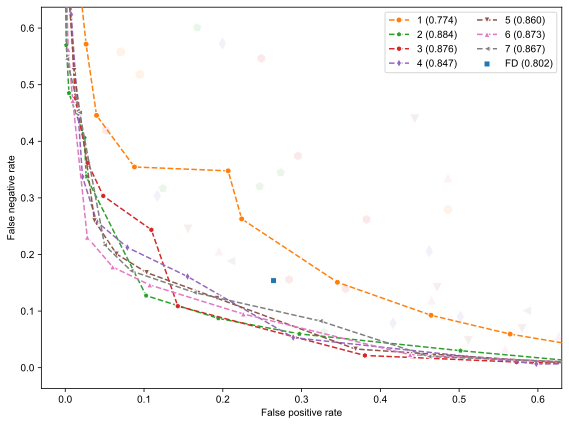

In [31]:
plt.figure(figsize=figsize)

plt.scatter(best_f1_full_dataset_dbscan['false_positive_rate'], best_f1_full_dataset_dbscan['false_negative_rate'], label='FD ({:.3f})'.format(best_f1_full_dataset_dbscan['f1_score']), 
            marker='s', edgecolors='white', zorder=30)

for idn, n_components in enumerate(performance_dbscan_tsne.keys()):
    
    sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_tsne[n_components])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)

    best_f1 = get_best_dbscan(performance_dbscan_tsne[n_components])
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker=markers[idn], s=80, alpha=0.1, edgecolors='white', zorder=1+idn)

    plt.plot(curve_fpr, curve_fnr, ls='--', marker=markers[idn], alpha=1., 
             markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10+idn, 
             label=f"{n_components} ({best_f1['f1_score']:.3f})")
    if idn == 6: break
xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
plt.xlim([xlim, .6 - xlim])
plt.ylim([ylim, .6 - ylim])
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
l = plt.legend(ncol=2, loc=1)
l.set_zorder(20)
plt.tight_layout()
plt.savefig('./figures/accuracy_dbscan_tsne.pdf')
plt.savefig('./figures/accuracy_dbscan_tsne.svg')
plt.show()
plt.close()

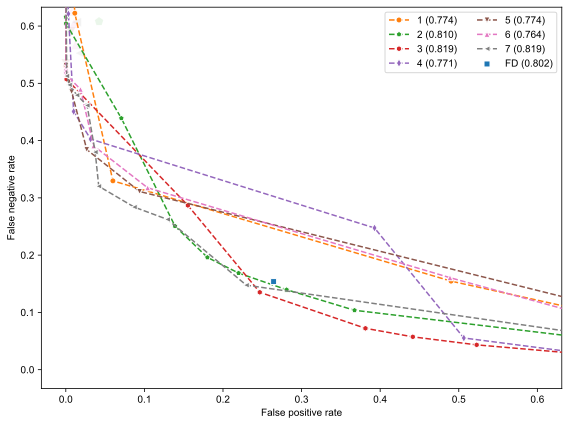

In [32]:
plt.figure(figsize=figsize)

plt.scatter(best_f1_full_dataset_dbscan['false_positive_rate'], best_f1_full_dataset_dbscan['false_negative_rate'], label='FD ({:.3f})'.format(best_f1_full_dataset_dbscan['f1_score']), 
            marker='s', edgecolors='white', zorder=30)

for idn, n_components in enumerate(performance_ocsvm_encoder.keys()):
    
    layer = (400, 100, 40)
    
    sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_encoder[n_components][layer])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)

    best_f1 = get_best_dbscan(performance_dbscan_encoder[n_components][layer])
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker=markers[idn], s=80, alpha=0.1, edgecolors='white', zorder=1+idn)

    plt.plot(curve_fpr, curve_fnr, ls='--', marker=markers[idn], alpha=1., 
             markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10+idn, 
             label=f"{n_components} ({best_f1['f1_score']:.3f})")
    if idn == 6: break
xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
plt.xlim([xlim, .6 - xlim])
plt.ylim([ylim, .6 - ylim])
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
l = plt.legend(ncol=2, loc=1)
l.set_zorder(30)
plt.tight_layout()
plt.savefig('./figures/accuracy_dbscan_ae.pdf')
plt.savefig('./figures/accuracy_dbscan_ae.svg')
plt.show()
plt.close()

In [33]:
with open('./models/scalability_results.h5', 'rb') as file:
    data = pickle.load(file)
    scalability_results = data['scalability_results']
    scalability_results_full = data['scalability_results_full']
    max_number_lightpaths = max([load for load, time in scalability_results_full['dbscan'].items()])

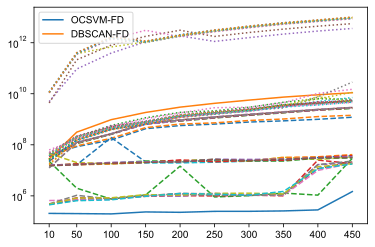

In [34]:
plt.figure(figsize=figsize)
plt.plot([load for load, time in scalability_results_full['ocsvm'].items()],
        [time for load, time in scalability_results_full['ocsvm'].items()], label='OCSVM-FD')

plt.plot([load for load, time in scalability_results_full['dbscan'].items()],
        [time for load, time in scalability_results_full['dbscan'].items()], label='DBSCAN-FD')

line_styles = dict(ocsvm='--', dbscan=':')

for alg in ['ocsvm', 'dbscan']:
    for dim in ['pca', 'tsne', 'ae']:
        for n_components in range(1, 9):
            plt.plot([load for load, time in scalability_results[alg][dim][n_components].items()],
                     [time for load, time in scalability_results[alg][dim][n_components].items()],
                    ls=line_styles[alg])

plt.yscale('log')
plt.xticks([x for x in scalability_results_full['dbscan'].keys()])
plt.legend()
plt.show()

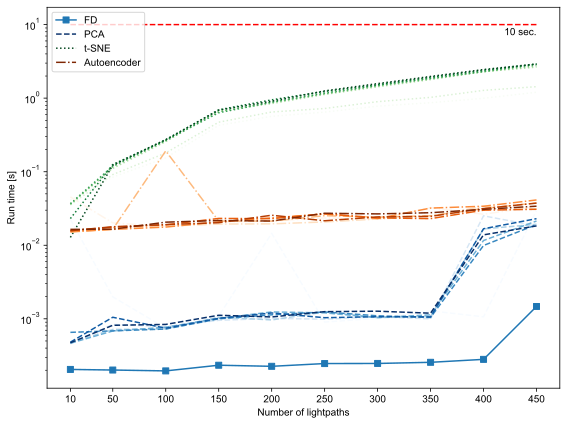

In [40]:
plt.figure(figsize=figsize)

c = np.arange(1, 8)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())

cmaps = {}
cmaps['pca'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmaps['tsne'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
cmaps['ae'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)

line_main, = plt.plot([load for load, time in scalability_results_full['ocsvm'].items()],
                    [time/1e9 for load, time in scalability_results_full['ocsvm'].items()], 
                      label='OCSVM-FD', marker='s')

line_styles = dict(pca='--', tsne=':', ae='-.')
alg = 'ocsvm'
lines = []
for dim in ['pca', 'tsne', 'ae']:
    for n_components in range(1, 8):
        line, = plt.plot([load for load, time in scalability_results[alg][dim][n_components].items()],
                [time/1e9 for load, time in scalability_results[alg][dim][n_components].items()],
                ls=line_styles[dim],
                color=cmaps[dim].to_rgba(n_components))
    lines.append(line)

plt.hlines(10, 10, max_number_lightpaths, ls='--', color='red')
plt.text(max_number_lightpaths, 9, '10 sec.', horizontalalignment='right', 
         verticalalignment='top')
plt.yscale('log')
plt.ylabel('Run time [s]')
plt.xlabel('Number of lightpaths')
plt.xticks([x for x in scalability_results_full['dbscan'].keys()])
plt.legend([line_main] + lines, ['FD', 'PCA', 't-SNE', 'Autoencoder'])
plt.tight_layout()
plt.savefig('./figures/runtime_ocsvm.pdf')
plt.savefig('./figures/runtime_ocsvm.svg')
plt.show()
plt.close()

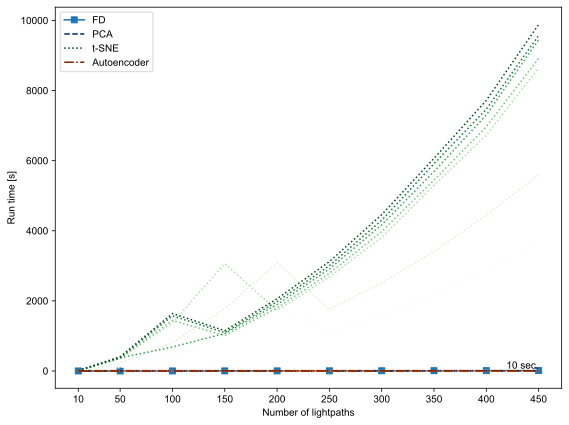

In [41]:
plt.figure(figsize=figsize)

c = np.arange(1, 8)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())

cmaps = {}
cmaps['pca'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmaps['tsne'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
cmaps['ae'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)

line_main, = plt.plot([load for load, time in scalability_results_full['dbscan'].items()],
                    [time/1e9 for load, time in scalability_results_full['dbscan'].items()], 
                      label='DBSCAN-FD', marker='s')

line_styles = dict(pca='--', tsne=':', ae='-.')
alg = 'dbscan'
lines = []
for dim in ['pca', 'tsne', 'ae']:
    for n_components in range(1, 8):
        line, = plt.plot([load for load, time in scalability_results[alg][dim][n_components].items()],
                [time/1e9 for load, time in scalability_results[alg][dim][n_components].items()],
                ls=line_styles[dim],
                color=cmaps[dim].to_rgba(n_components))
    lines.append(line)

plt.hlines(10, 10, max_number_lightpaths, ls='--', color='red')
plt.text(max_number_lightpaths, 11, '10 sec.', horizontalalignment='right', verticalalignment='bottom')
# plt.yscale('log')
plt.ylabel('Run time [s]')
plt.xlabel('Number of lightpaths')
plt.xticks([x for x in scalability_results_full['dbscan'].keys()])
plt.legend([line_main] + lines, ['FD', 'PCA', 't-SNE', 'Autoencoder'], loc=2)
plt.tight_layout()
plt.savefig('./figures/runtime_dbscan.pdf')
plt.savefig('./figures/runtime_dbscan.svg')
plt.show()
plt.close()

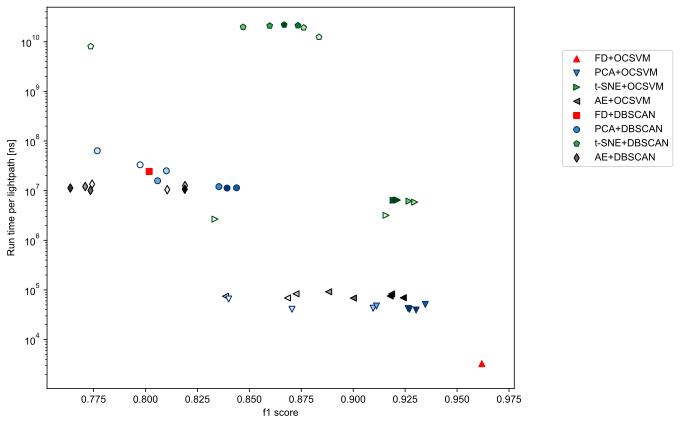

In [37]:
plt.figure(figsize=[figsize[0]+2, figsize[1]])

cmaps = {}
cmaps['pca'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmaps['tsne'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
cmaps['ae'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys)

lines = []

line = plt.scatter(best_f1_full_dataset_ocsvm['f1_score'], 
            scalability_results_full['ocsvm'][max_number_lightpaths]/max_number_lightpaths, 
            label='OCSVM-FD', 
            marker='^', zorder=30, color='red')
lines.append(line)

for idn, n_components in enumerate(performance_ocsvm_encoder.keys()):
    
    best_f1 = get_best_ocsvm(performance_ocsvm_pca[n_components])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['ocsvm']['pca'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['pca'].to_rgba(n_components), edgecolors=cmaps['pca'].to_rgba(8), marker='v', zorder=idn+1)
    
    if idn == 4:
        lines.append(line)
    
    best_f1 = get_best_ocsvm(performance_ocsvm_tsne[n_components])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['ocsvm']['tsne'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['tsne'].to_rgba(n_components), edgecolors=cmaps['tsne'].to_rgba(8), marker='>', zorder=idn)
    
    if idn == 4:
        lines.append(line)
    
    layer = (400, 100, 40)
    best_f1 = get_best_ocsvm(performance_ocsvm_encoder[n_components][layer])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['ocsvm']['ae'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['ae'].to_rgba(n_components), edgecolors=cmaps['ae'].to_rgba(8), marker='<', zorder=idn)
    
    if idn == 4:
        lines.append(line)
        
line = plt.scatter(best_f1_full_dataset_dbscan['f1_score'], 
            scalability_results_full['dbscan'][max_number_lightpaths]/max_number_lightpaths, 
            label='DBSCAN-FD', 
            marker='s', zorder=30, color='red')
lines.append(line)

for idn, n_components in enumerate(performance_ocsvm_encoder.keys()):
    
    best_f1 = get_best_dbscan(performance_dbscan_pca[n_components])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['dbscan']['pca'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['pca'].to_rgba(n_components), edgecolors=cmaps['pca'].to_rgba(8), marker='o', zorder=idn)
    
    if idn == 4:
        lines.append(line)
    
    best_f1 = get_best_dbscan(performance_dbscan_tsne[n_components])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['dbscan']['tsne'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['tsne'].to_rgba(n_components), edgecolors=cmaps['tsne'].to_rgba(8), marker='p', zorder=idn)
    
    if idn == 4:
        lines.append(line)
    
    layer = (400, 100, 40)
    best_f1 = get_best_dbscan(performance_dbscan_encoder[n_components][layer])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['dbscan']['ae'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['ae'].to_rgba(n_components), edgecolors=cmaps['ae'].to_rgba(8), marker='d', zorder=idn)
    
    if idn == 4:
        lines.append(line)
    
    if idn == 6: break
# xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
# plt.xlim([xlim, .6 - xlim])
# plt.ylim([ylim, .6 - ylim])
plt.xlabel('f1 score')
plt.ylabel('Run time per lightpath [ns]')
plt.yscale('log')
box = plt.gca().get_position()
# plt.gca().set_position([box.x0, box.y0, box.width * 0.5, box.height])
l = plt.legend(lines, ['FD+OCSVM', 'PCA+OCSVM', 't-SNE+OCSVM', 'AE+OCSVM', 
                       'FD+DBSCAN', 'PCA+DBSCAN', 't-SNE+DBSCAN', 'AE+DBSCAN'], 
               ncol=1, loc=1, bbox_to_anchor=(1.35, .9))
l.set_zorder(30)
plt.tight_layout()
plt.savefig('./figures/runtime_accuracy_tradeoff.pdf')
plt.savefig('./figures/runtime_accuracy_tradeoff.svg')
plt.show()
plt.close()

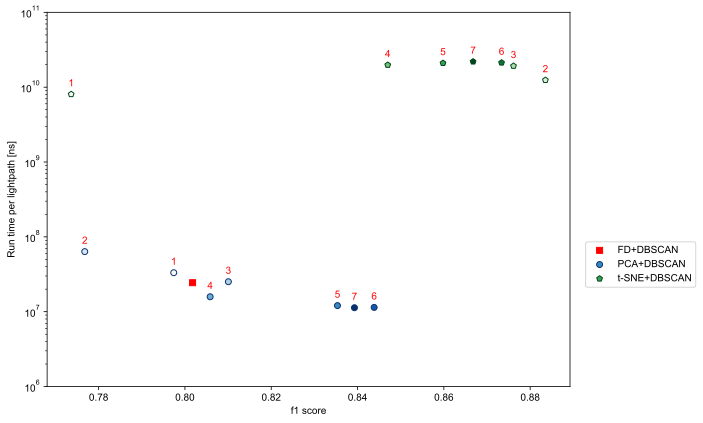

In [43]:
plt.figure(figsize=[figsize[0]+2, figsize[1]])

cmaps = {}
cmaps['pca'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmaps['tsne'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
cmaps['ae'] = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys)

lines = []
        
line = plt.scatter(best_f1_full_dataset_dbscan['f1_score'], 
            scalability_results_full['dbscan'][max_number_lightpaths]/max_number_lightpaths, 
            label='DBSCAN-FD', 
            marker='s', zorder=30, color='red')
lines.append(line)

time_fd = scalability_results_full['dbscan'][max_number_lightpaths]/max_number_lightpaths

for idn, n_components in enumerate(performance_dbscan_encoder.keys()):
    
    best_f1 = get_best_dbscan(performance_dbscan_pca[n_components])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['dbscan']['pca'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['pca'].to_rgba(n_components), edgecolors=cmaps['pca'].to_rgba(8), marker='o', zorder=idn)

    plt.text(best_f1['f1_score'], 
                (scalability_results['dbscan']['pca'][n_components][max_number_lightpaths]/max_number_lightpaths)+(scalability_results['dbscan']['pca'][n_components][max_number_lightpaths]/max_number_lightpaths)/5, f'{n_components}',
             horizontalalignment='center', verticalalignment='bottom', color='red', zorder=idn+1)

    if idn == 4:
        lines.append(line)
    
    best_f1 = get_best_dbscan(performance_dbscan_tsne[n_components])
    line = plt.scatter(best_f1['f1_score'], 
                scalability_results['dbscan']['tsne'][n_components][max_number_lightpaths]/max_number_lightpaths, 
                color=cmaps['tsne'].to_rgba(n_components), edgecolors=cmaps['tsne'].to_rgba(8), marker='p', zorder=idn)
    
    plt.text(best_f1['f1_score'], 
                (scalability_results['dbscan']['tsne'][n_components][max_number_lightpaths]/max_number_lightpaths)+(scalability_results['dbscan']['tsne'][n_components][max_number_lightpaths]/max_number_lightpaths)/5, f'{n_components}',
             horizontalalignment='center', verticalalignment='bottom', color='red', zorder=idn+1)

    if idn == 4:
        lines.append(line)
    
    if idn == 6: break
# xlim, ylim = plt.xlim()[0]/2., plt.ylim()[0]/2.
# plt.xlim([xlim, .6 - xlim])
# plt.ylim([ylim, .6 - ylim])
plt.xlabel('f1 score')
plt.ylabel('Run time per lightpath [ns]')
plt.yscale('log')
plt.ylim([10e5, 10e10])

l = plt.legend(lines, ['FD+DBSCAN', 'PCA+DBSCAN', 't-SNE+DBSCAN'], 
               ncol=1, loc=1, bbox_to_anchor=(1.25, .4))
l.set_zorder(30)
plt.tight_layout()
plt.savefig('./figures/runtime_accuracy_tradeoff_dbscan.pdf')
plt.savefig('./figures/runtime_accuracy_tradeoff_dbscan.svg')
plt.show()
plt.close()